# Regression

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
pip install -q seaborn 

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

2023-09-22 22:04:38.668394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)

In [125]:
dataset = raw_dataset.copy()
print("len: ", len(dataset))
dataset.tail()

len:  398


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [126]:
print(dataset.isna().sum())
dataset = dataset.dropna()
print("len: ", len(dataset))

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
len:  392


In [38]:
# can be done with keras utils.to_categorical
# tf.keras.layers.CategoryEncoding

# Origin is categorical, not numeric. So convert it to one-hot:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='', columns=['Origin'])
dataset.tail()

# if KeyError: 'Origin' then rerune the cell with: dataset = raw_dataset.copy()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


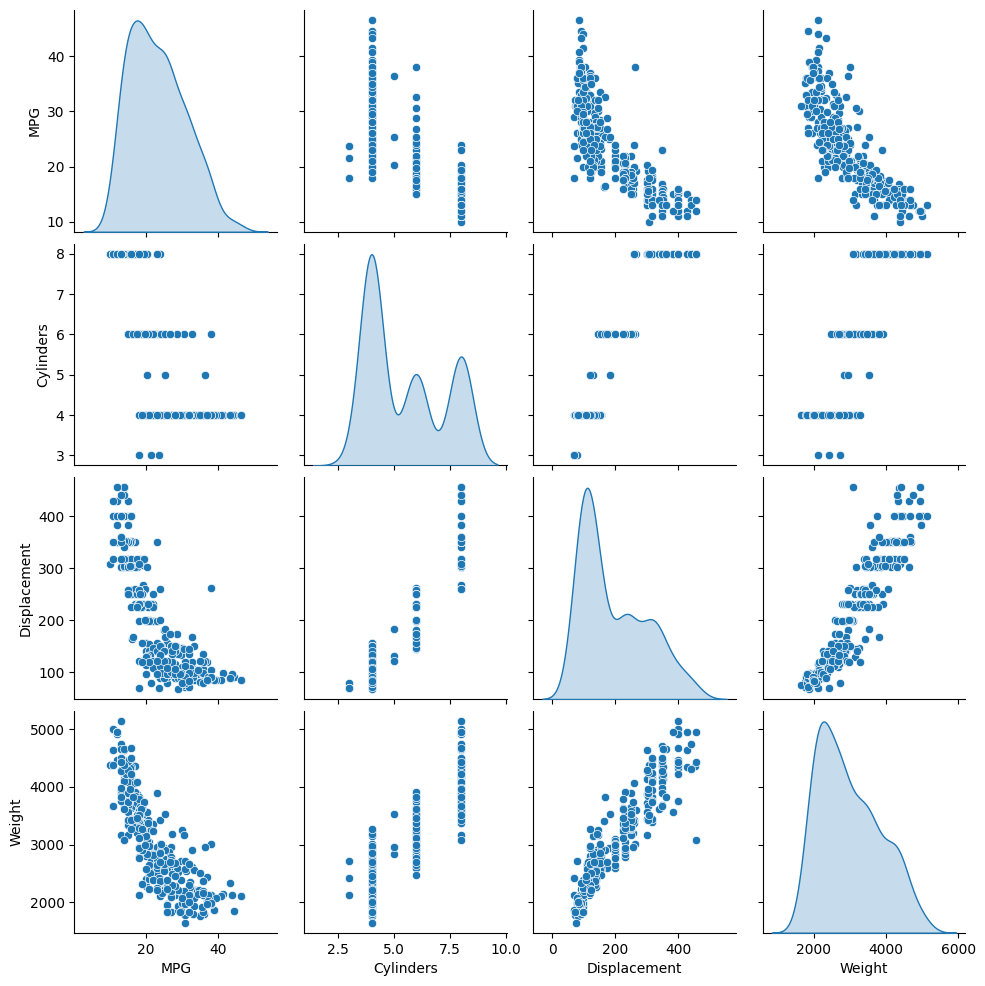

In [128]:
train_ds = dataset.sample(frac=0.8, random_state=0)
test_ds = dataset.drop(train_ds.index)

# Pairwise Relationship: Overall, pairplot is used for quickly examining the pairwise relationships
#  between variables and is especially useful for exploring the potential relationships and patterns in the dataset.
# diag_kind='kde' - Kernel Density Estimation
sns.pairplot(train_ds[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [129]:
train_ds.describe().transpose().sort_values(by=['std'], ascending=[False])

,count,mean,std,min,25%,50%,75%,max
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


In [180]:
train_features = train_ds.copy()
# <class 'pandas.core.frame.DataFrame'>
# heterogenous data, 2 dimensional, sql like, columns/rows
print(type(train_features))
# <class 'numpy.ndarray'>
# homogenous data, N dimensional, math like (element-wise computation), tensor
print(type(np.array(train_features)))
test_features = test_ds.copy()

# target training data. 
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [136]:
# It is good practice to normalize features that use different scales and ranges.
# One reason this is important is because the features are multiplied by the model weights. 
# So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
# normalization makes training much more stable.


# The axis parameter specifies the dimension of the tensor along which a certain operation is to be performed. 
# axis = to apply the normalizatio; deafult is -1, which indicates the feature/column axis.
normalizer = tf.keras.layers.Normalization(axis=-1)
# The mean and variance values for the layer must be either supplied on construction or learned via adapt().
# adapt() will compute the mean and variance of the data and store them as the layer's weights. 
# adapt() should be called before fit(), evaluate(), or predict().
normalizer.adapt(np.array(train_features))

# reshaping with .reshape(-1, 1) will convert it to a column vector.
# print(normalizer.mean.numpy())

first = np.array(train_features[:1])
print('class type: ', type(normalizer(first)))

with np.printoptions(precision=3, suppress=True):
  print('First example:', first)
  print('Normalized:', normalizer(first).numpy())


class type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
First example: [[   4.    90.    75.  2125.    14.5   74.     1. ]]
Normalized: [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517 -0.717]]


#### Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

#### Linear regression with one variable

Begin with a single-variable linear regression to predict 'MPG' from 'Horsepower'.


In [137]:
hp = np.array(train_features['Horsepower'])
hp_n = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
# adapt computes the mean and variance, and stores them in the layer.
hp_n.adapt(hp)

In [139]:
hp_model = tf.keras.Sequential([
  hp_n,
  tf.keras.layers.Dense(units=1)
], name='horsepower_model__sequential_1')

hp_model.summary()

Model: "horsepower_model__sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_25 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [140]:
# poor prediction, but correct shape (10, 1)
hp_model.predict(hp[:10])


1/1 [==============================] - 0s 58ms/step


array([[ 1.245],
       [ 0.703],
       [-2.299],
       [ 1.746],
       [ 1.579],
       [ 0.62 ],
       [ 1.871],
       [ 1.579],
       [ 0.411],
       [ 0.703]], dtype=float32)

In [276]:
hp_model.compile(
  # Adam is a gradient-based optimization algorithm based on adaptive estimation of first-order and second-order moments.
  # extension of the SGD method.
  optimizer=tf.optimizers.Adam(learning_rate=0.1),
  loss='mean_squared_error'
)

In [277]:
fit_history = hp_model.fit(
  train_features['Horsepower'],
  train_labels,
  epochs=100,
  verbose=0,
  validation_split=0.2
)

In [280]:
hist = pd.DataFrame(fit_history.history)
hist['epoch'] = fit_history.epoch
print(hist.head())
print(hist.tail())

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
  plt.show()

        loss   val_loss  epoch
0  25.478151  24.637037      0
1  25.022467  24.025425      1
2  24.968159  23.787544      2
3  25.081188  23.692375      3
4  24.995522  23.766878      4
         loss   val_loss  epoch
95  25.002268  23.848242     95
96  25.013159  23.951511     96
97  25.089684  23.841629     97
98  24.988871  23.892788     98
99  25.009684  23.932667     99


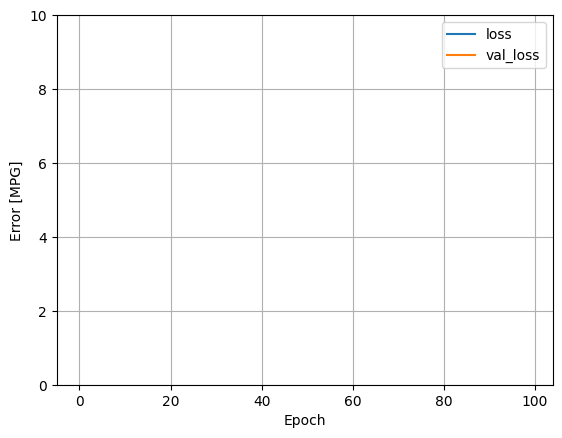

In [281]:
plot_loss(fit_history)

In [157]:
test_result = {}

test_result['hp_model'] = hp_model.evaluate(
  test_features['Horsepower'],
  test_labels,
  verbose=0
)

print("Loss:", test_result['hp_model'])
# print(f"Metric Value: {test_result['hp_model'][1]}")


Loss: 3.644840717315674


8/8 [==============================] - 0s 1ms/step


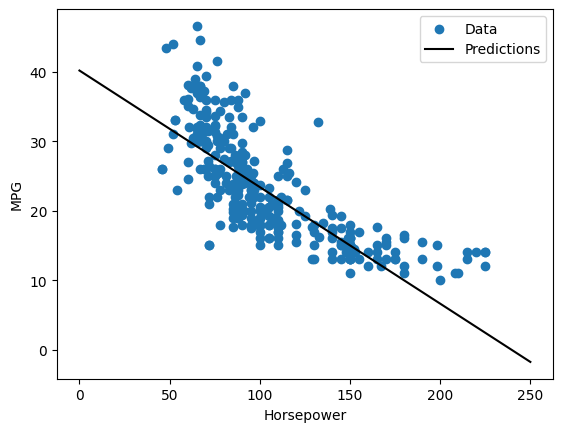

In [158]:
x = tf.linspace(0.0, 250, 251)
y = hp_model.predict(x)


def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x, y)

END single input linear model

### START multiple intput linear model


In [189]:
linear_model = tf.keras.Sequential([
  normalizer,
  # units=1, defines the output #
  tf.keras.layers.Dense(units=1)
])

In [190]:
pre_train_prediction = linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 97ms/step


In [191]:
linear_model.layers[1].kernel


<tf.Variable 'dense_4/kernel:0' shape=(7, 1) dtype=float32, numpy=
array([[ 0.36 ],
       [ 0.138],
       [ 0.504],
       [-0.156],
       [ 0.237],
       [-0.795],
       [ 0.516]], dtype=float32)>

In [192]:
linear_model.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.1),
  loss='mean_absolute_error'
)

In [193]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

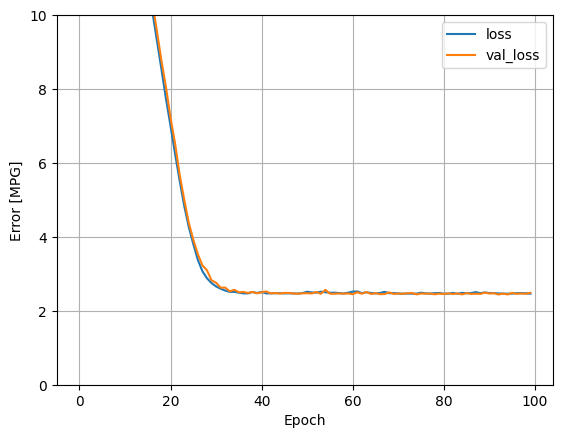

In [194]:
plot_loss(history)

In [195]:
test_result['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [196]:
test_result

{'hp_model': 3.644840717315674, 'linear_model': 2.541719436645508}

In [206]:
print(pre_train_prediction)
print(linear_model.predict(test_features[7:10]))
print(test_labels[7:10])

[[-0.738]
 [-1.486]
 [ 1.5  ]
 [-2.593]
 [-0.55 ]
 [-0.764]
 [-0.553]
 [-1.011]
 [ 0.084]
 [ 1.305]]
1/1 [==============================] - 0s 31ms/step
[[10.902]
 [19.506]
 [28.75 ]]
43    13.0
48    18.0
54    35.0
Name: MPG, dtype: float64


### DNN w/ regression


In [241]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [242]:
dnn_hp_model = build_and_compile_model(hp_n)
dnn_hp_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_25 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
 dense_26 (Dense)            (None, 64)                128       
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)


Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [243]:
history = dnn_hp_model.fit(
  train_features['Horsepower'],
  train_labels,
  epochs=100,
  verbose=0,
  validation_split=0.2,
)

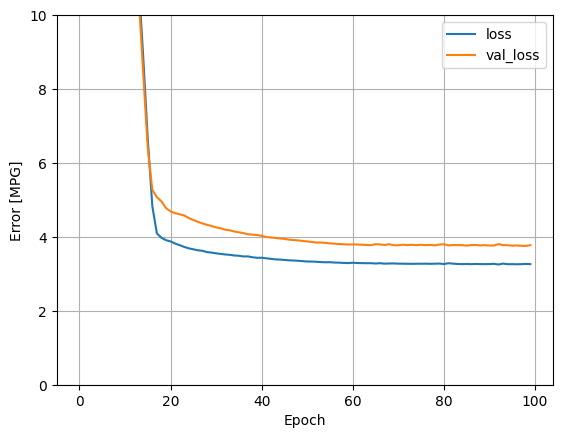

In [244]:
plot_loss(history)

8/8 [==============================] - 0s 1ms/step


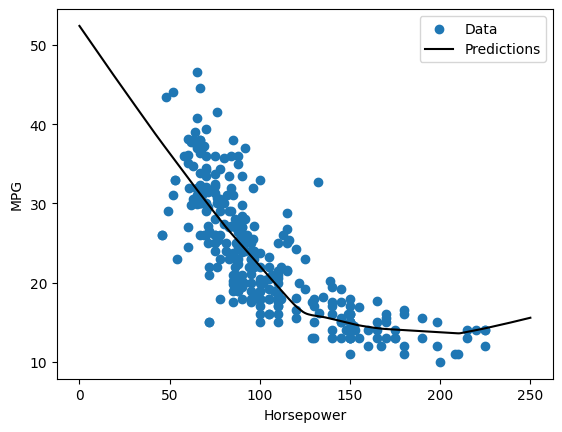

In [245]:
x = tf.linspace(0.0, 250, 251)
y = dnn_hp_model.predict(x)
plot_horsepower(x, y)

In [246]:
test_result['dnn_hp_model'] = dnn_hp_model.evaluate(
  test_features['Horsepower'],
  test_labels,
  verbose=0
)
test_result

{'hp_model': 3.644840717315674,
 'linear_model': 2.541719436645508,
 'dnn_hp_model': 2.905717372894287}

### Regression DNN multiple inputs


In [247]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_24 (Normaliz  (None, 7)                 15        
 ation)                                                          
                                                                 
 dense_29 (Dense)            (None, 64)                512       
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4752 (18.57 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 15 (64.00 Byte)
_________________________________________________________________


In [248]:
history = dnn_model.fit(
  train_features,
  train_labels,
  validation_split=0.2,
  epochs=100,
  verbose=0
)

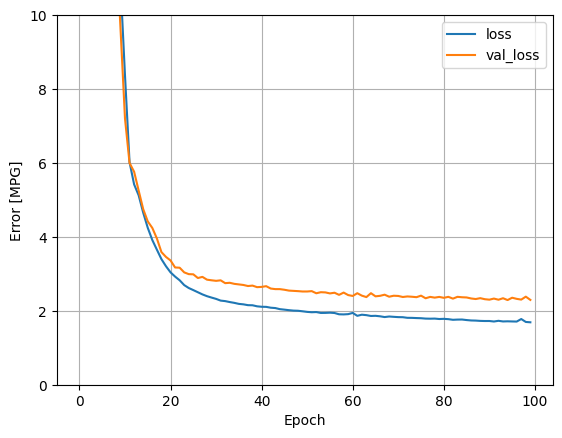

In [249]:
plot_loss(history)

In [256]:
test_result['dnn_model'] = dnn_model.evaluate(
  test_features,
  test_labels,
  verbose=0
)
pd.DataFrame(test_result, index=['MSE for MPG']).T

,MSE for MPG
hp_model,3.644841
linear_model,2.541719
dnn_hp_model,2.905717
dnn_model,1.821110


8/8 [==============================] - 0s 4ms/step


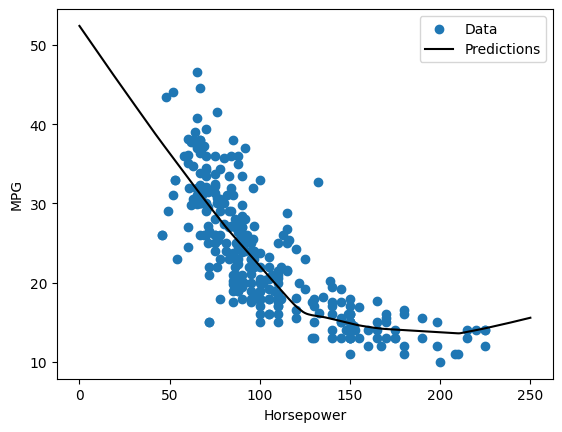

In [252]:
x = tf.linspace(0.0, 250, 251)
y = dnn_hp_model.predict(x)
plot_horsepower(x, y)

3/3 [==============================] - 0s 3ms/step


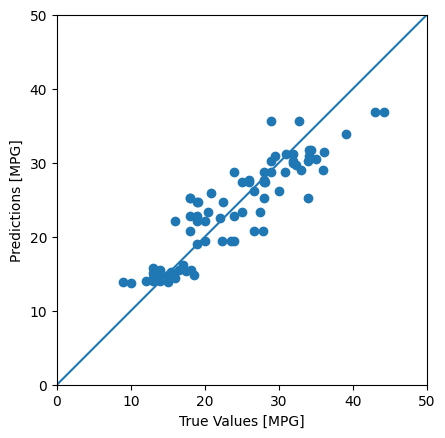

In [260]:
test_predictions = dnn_hp_model.predict(test_features['Horsepower']).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

3/3 [==============================] - 0s 3ms/step


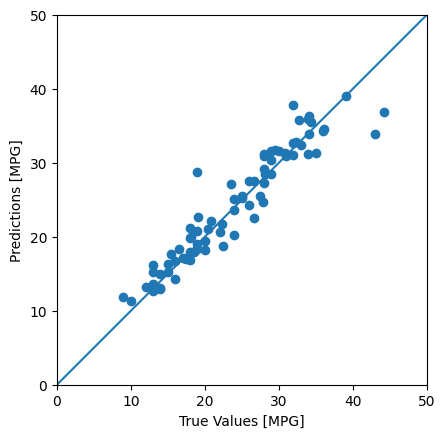

In [261]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

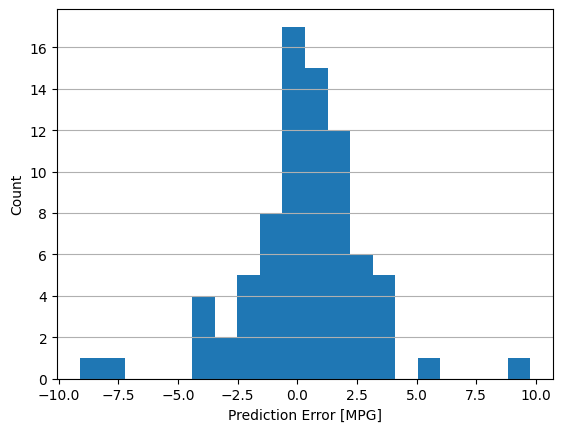

In [266]:
error = test_predictions - test_labels
plt.hist(error, bins=20)
plt.xlabel('Prediction Error [MPG]')
plt.grid(axis='y')
_ = plt.ylabel('Count')

In [268]:
dnn_model.save(filepath='./models/dnn_auto_mpg_model')

INFO:tensorflow:Assets written to: ./models/dnn_auto_mpg_model/assets


INFO:tensorflow:Assets written to: ./models/dnn_auto_mpg_model/assets


In [269]:
loaded_dnn_model = tf.keras.models.load_model(filepath='./models/dnn_auto_mpg_model')
test_result['reloaded_dnn_model'] = loaded_dnn_model.evaluate(
  test_features,
  test_labels,
  verbose=0
)

In [273]:
pd.DataFrame(test_result, index=['MSE for MPG']).T

,MSE for MPG
hp_model,3.644841
linear_model,2.541719
dnn_hp_model,2.905717
dnn_model,1.821110
reloaded_dnn_model,1.821110
